In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, ViTModel
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
from tqdm import tqdm  # Import tqdm for progress bars

# --- Dataset and Preprocessing ---

class CrisisDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_transform):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Tokenize tweet text (using a max length of 128 tokens)
        encoding = self.tokenizer(
            row['tweet_text'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()       # (max_length,)
        attention_mask = encoding['attention_mask'].squeeze()  # (max_length,)

        # Load image (assuming the path stored in the dataframe is valid)
        image_path = row['image']
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)

        # Convert string labels to binary (1 for "informative", 0 for "not_informative")
        label = 1.0 if row['label'] == "informative" else 0.0
        label_text = 1.0 if row['label_text'] == "informative" else 0.0
        label_image = 1.0 if row['label_image'] == "informative" else 0.0

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.float),
            'label_text': torch.tensor(label_text, dtype=torch.float),
            'label_image': torch.tensor(label_image, dtype=torch.float)
        }

# Define image transformations for ViT (resize, normalization, etc.)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Example normalization; adjust mean and std as needed for your pretrained ViT model
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load your CSV/TSV files (adjust file paths as needed)
train_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
dev_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')

# Create dataset and dataloaders
train_dataset = CrisisDataset(train_df, tokenizer, image_transform)
dev_dataset = CrisisDataset(dev_df, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

# --- Model Definition with Gated Fusion for Multimodal Branch ---

class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        # Load pretrained encoders for text and image.
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        # Use a pretrained ViT; note that "google/vit-base-patch16-224-in21k" outputs 768-dim embeddings.
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Both models output embeddings of size 768 so that they share a common space.
        hidden_size = self.text_encoder.config.hidden_size
        
        self.dropout = nn.Dropout(0.1)
        # --- Multimodal branch using gated fusion ---
        # Gating layer: takes the sum of text and image embeddings and outputs gate values.
        self.gate_layer = nn.Linear(hidden_size, hidden_size)
        # Classifier on the fused representation.
        self.classifier = nn.Linear(hidden_size, 1)
        
        # --- Individual modality heads ---
        # Text-only head (hidden_size input)
        self.text_head = nn.Linear(hidden_size, 1)
        # Image-only head (hidden_size input)
        self.image_head = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, image):
        # Text encoding
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output  # shape: (batch, hidden_size)
        
        # Image encoding
        image_outputs = self.image_encoder(pixel_values=image)
        image_embeds = image_outputs.pooler_output  # shape: (batch, hidden_size)
        
        # --- Gated fusion for multimodal representation ---
        gate = torch.sigmoid(self.gate_layer(text_embeds + image_embeds))  # (batch, hidden_size)
        fused = gate * text_embeds + (1 - gate) * image_embeds  # (batch, hidden_size)
        multimodal_logits = self.classifier(self.dropout(fused))
        
        # Text-only and image-only branches
        text_logits = self.text_head(self.dropout(text_embeds))
        image_logits = self.image_head(self.dropout(image_embeds))
        
        return multimodal_logits, text_logits, image_logits

# --- Training Setup ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Simple function to compute binary accuracy
def compute_accuracy(logits, labels):
    # Convert logits to probabilities and then to predictions (threshold=0.5)
    preds = (torch.sigmoid(logits) > 0.5).float()
    correct = (preds == labels.unsqueeze(1)).sum().item()
    return correct / labels.size(0)

# --- Training Loop with Alternating Epochs and Loading Bars ---
# Now we train for 6 epochs total, i.e., 2 epochs for each head (multimodal, text, image).

num_cycles = 2  # 2 cycles (2 epochs per head)
total_epochs = num_cycles * 3  # 6 epochs total

for epoch in range(total_epochs):
    if epoch % 3 == 0:
        current_head = "multimodal"
        print(f"\nEpoch {epoch+1}: Training Multimodal (gated fusion) head")
    elif epoch % 3 == 1:
        current_head = "text"
        print(f"\nEpoch {epoch+1}: Training Text-only head")
    else:
        current_head = "image"
        print(f"\nEpoch {epoch+1}: Training Image-only head")
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # Training phase with loading bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        
        multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
        
        if current_head == "multimodal":
            logits = multimodal_logits
            targets = batch['label'].to(device)
        elif current_head == "text":
            logits = text_logits
            targets = batch['label_text'].to(device)
        else:
            logits = image_logits
            targets = batch['label_image'].to(device)
        
        loss = criterion(logits, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * input_ids.size(0)
        running_corrects += compute_accuracy(logits, targets) * input_ids.size(0)
        total_samples += input_ids.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    print(f"Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f}")
    
    # Validation phase with loading bar
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(dev_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
            
            if current_head == "multimodal":
                logits = multimodal_logits
                targets = batch['label'].to(device)
            elif current_head == "text":
                logits = text_logits
                targets = batch['label_text'].to(device)
            else:
                logits = image_logits
                targets = batch['label_image'].to(device)
            
            loss = criterion(logits, targets.unsqueeze(1))
            val_loss += loss.item() * input_ids.size(0)
            val_corrects += compute_accuracy(logits, targets) * input_ids.size(0)
            val_samples += input_ids.size(0)
    
    val_epoch_loss = val_loss / val_samples
    val_epoch_acc = val_corrects / val_samples
    print(f"Validation Loss: {val_epoch_loss:.4f} | Validation Accuracy: {val_epoch_acc:.4f}")


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch 1: Training Multimodal (gated fusion) head


Epoch 1 Training:  11%|█         | 94/851 [01:16<09:54,  1.27it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1 Training: 100%|██████████| 851/851 [13:09<00:00,  1.08it/s]


Training Loss: 0.4734 | Training Accuracy: 0.7676


Epoch 1 Validation: 100%|██████████| 140/140 [01:02<00:00,  2.23it/s]


Validation Loss: 0.4408 | Validation Accuracy: 0.7792

Epoch 2: Training Text-only head


Epoch 2 Training: 100%|██████████| 851/851 [31:22<00:00,  2.21s/it]


Training Loss: 0.3317 | Training Accuracy: 0.8640


Epoch 2 Validation: 100%|██████████| 140/140 [00:52<00:00,  2.66it/s]


Validation Loss: 0.4022 | Validation Accuracy: 0.8342

Epoch 3: Training Image-only head


Epoch 3 Training: 100%|██████████| 851/851 [1:09:34<00:00,  4.91s/it]


Training Loss: 0.3297 | Training Accuracy: 0.8625


Epoch 3 Validation: 100%|██████████| 140/140 [02:00<00:00,  1.16it/s]


Validation Loss: 0.3616 | Validation Accuracy: 0.8458

Epoch 4: Training Multimodal (gated fusion) head


Epoch 4 Training: 100%|██████████| 851/851 [50:30<00:00,  3.56s/it]


Training Loss: 0.2741 | Training Accuracy: 0.8698


Epoch 4 Validation: 100%|██████████| 140/140 [01:50<00:00,  1.27it/s]


Validation Loss: 0.4977 | Validation Accuracy: 0.7778

Epoch 5: Training Text-only head


Epoch 5 Training: 100%|██████████| 851/851 [35:01<00:00,  2.47s/it]


Training Loss: 0.1902 | Training Accuracy: 0.9307


Epoch 5 Validation: 100%|██████████| 140/140 [02:44<00:00,  1.18s/it]


Validation Loss: 0.4835 | Validation Accuracy: 0.8283

Epoch 6: Training Image-only head


Epoch 6 Training: 100%|██████████| 851/851 [1:11:56<00:00,  5.07s/it]


Training Loss: 0.1650 | Training Accuracy: 0.9352


Epoch 6 Validation: 100%|██████████| 140/140 [01:47<00:00,  1.30it/s]

Validation Loss: 0.4038 | Validation Accuracy: 0.8489


Extracting features for TSNE: 100%|██████████| 140/140 [01:46<00:00,  1.31it/s]
C:\Users\Aman\AppData\Local\Temp\ipykernel_21544\188613559.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


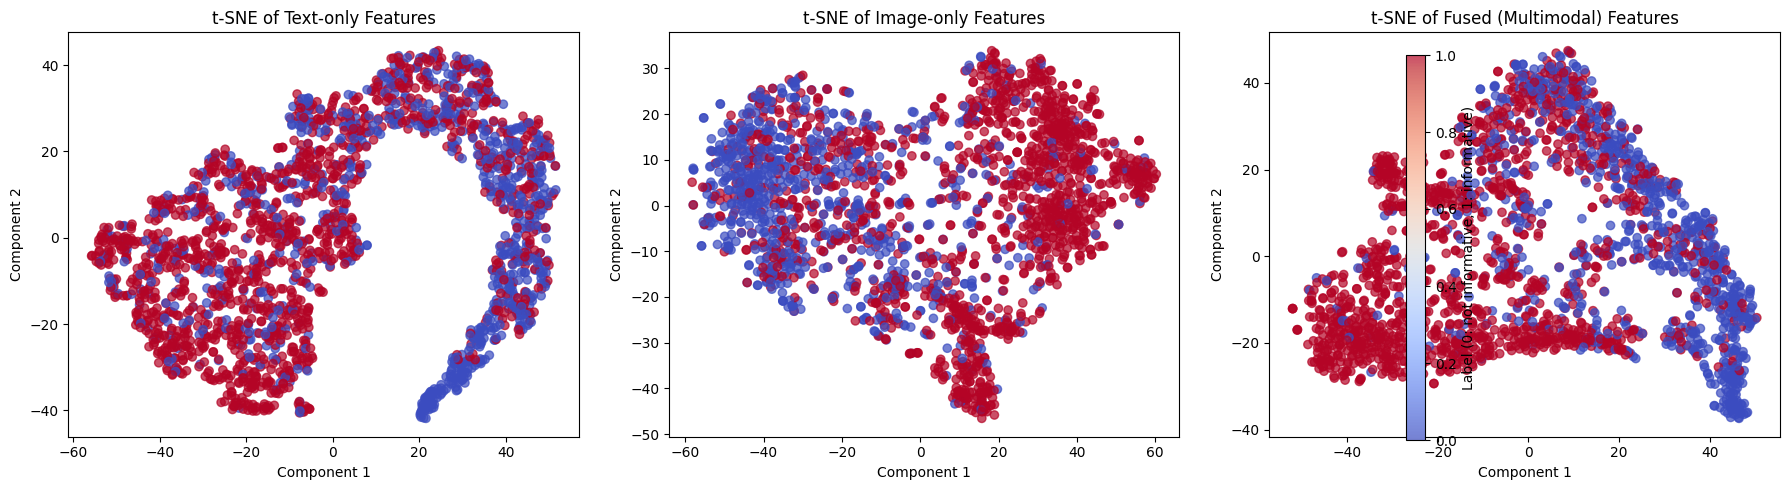

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()

all_text_features = []
all_image_features = []
all_fused_features = []
all_labels = []

# Extract features for each branch on the dev set
with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Extracting features for TSNE"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        
        # Text embeddings
        text_outputs = model.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output  # shape: (batch_size, hidden_size)
        
        # Image embeddings
        image_outputs = model.image_encoder(pixel_values=images)
        image_embeds = image_outputs.pooler_output  # shape: (batch_size, hidden_size)
        
        # Fused (multimodal) features via gated fusion
        gate = torch.sigmoid(model.gate_layer(text_embeds + image_embeds))
        fused_features = gate * text_embeds + (1 - gate) * image_embeds
        
        # Collect features and labels (using the multimodal label; adjust if needed)
        all_text_features.append(text_embeds.cpu().numpy())
        all_image_features.append(image_embeds.cpu().numpy())
        all_fused_features.append(fused_features.cpu().numpy())
        labels = batch['label'].cpu().numpy()
        all_labels.append(labels)

# Concatenate features and labels from all batches
all_text_features = np.concatenate(all_text_features, axis=0)
all_image_features = np.concatenate(all_image_features, axis=0)
all_fused_features = np.concatenate(all_fused_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Apply t-SNE to each representation separately
tsne_text = TSNE(n_components=2, random_state=42)
text_2d = tsne_text.fit_transform(all_text_features)

tsne_image = TSNE(n_components=2, random_state=42)
image_2d = tsne_image.fit_transform(all_image_features)

tsne_fused = TSNE(n_components=2, random_state=42)
fused_2d = tsne_fused.fit_transform(all_fused_features)

# Create subplots to visualize all three TSNE results
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

scatter0 = axs[0].scatter(text_2d[:, 0], text_2d[:, 1],
                          c=all_labels, cmap='coolwarm', alpha=0.7)
axs[0].set_title("t-SNE of Text-only Features")
axs[0].set_xlabel("Component 1")
axs[0].set_ylabel("Component 2")

scatter1 = axs[1].scatter(image_2d[:, 0], image_2d[:, 1],
                          c=all_labels, cmap='coolwarm', alpha=0.7)
axs[1].set_title("t-SNE of Image-only Features")
axs[1].set_xlabel("Component 1")
axs[1].set_ylabel("Component 2")

scatter2 = axs[2].scatter(fused_2d[:, 0], fused_2d[:, 1],
                          c=all_labels, cmap='coolwarm', alpha=0.7)
axs[2].set_title("t-SNE of Fused (Multimodal) Features")
axs[2].set_xlabel("Component 1")
axs[2].set_ylabel("Component 2")

# Add a common colorbar for the labels
fig.colorbar(scatter2, ax=axs, label='Label (0: not informative, 1: informative)')
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# --- Load and Filter Test Data ---
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_df = pd.read_csv(test_file_path, sep='\t')

# Filter test data to only include rows where label_text_image is "Positive"
test_df = test_df[test_df['label_text_image'] == "Positive"]

# Create test dataset and dataloader
test_dataset = CrisisDataset(test_df, tokenizer, image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- Evaluation on Test Data for All Three Branches ---
model.eval()

# Containers for predictions and true labels for each branch
all_preds_multimodal = []
all_true_multimodal = []
all_preds_text = []
all_true_text = []
all_preds_image = []
all_true_image = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing All Branches"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        
        # Forward pass through the model to get outputs for all branches
        multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
        
        # Compute predictions (threshold at 0.5)
        preds_multimodal = (torch.sigmoid(multimodal_logits) > 0.5).float().cpu().numpy()
        preds_text = (torch.sigmoid(text_logits) > 0.5).float().cpu().numpy()
        preds_image = (torch.sigmoid(image_logits) > 0.5).float().cpu().numpy()
        
        # Get true labels for each branch
        labels_multimodal = batch['label'].cpu().numpy()
        labels_text = batch['label_text'].cpu().numpy()
        labels_image = batch['label_image'].cpu().numpy()
        
        # Append batch predictions and true labels
        all_preds_multimodal.extend(preds_multimodal)
        all_true_multimodal.extend(labels_multimodal)
        all_preds_text.extend(preds_text)
        all_true_text.extend(labels_text)
        all_preds_image.extend(preds_image)
        all_true_image.extend(labels_image)

# Convert lists to numpy arrays and flatten them
all_preds_multimodal = np.array(all_preds_multimodal).flatten()
all_true_multimodal = np.array(all_true_multimodal).flatten()
all_preds_text = np.array(all_preds_text).flatten()
all_true_text = np.array(all_true_text).flatten()
all_preds_image = np.array(all_preds_image).flatten()
all_true_image = np.array(all_true_image).flatten()

# --- Compute Metrics for Each Branch ---

# Multimodal Branch
accuracy_multimodal = accuracy_score(all_true_multimodal, all_preds_multimodal)
precision_multimodal = precision_score(all_true_multimodal, all_preds_multimodal)
recall_multimodal = recall_score(all_true_multimodal, all_preds_multimodal)
f1_multimodal = f1_score(all_true_multimodal, all_preds_multimodal)

# Text-only Branch
accuracy_text = accuracy_score(all_true_text, all_preds_text)
precision_text = precision_score(all_true_text, all_preds_text)
recall_text = recall_score(all_true_text, all_preds_text)
f1_text = f1_score(all_true_text, all_preds_text)

# Image-only Branch
accuracy_image = accuracy_score(all_true_image, all_preds_image)
precision_image = precision_score(all_true_image, all_preds_image)
recall_image = recall_score(all_true_image, all_preds_image)
f1_image = f1_score(all_true_image, all_preds_image)

# --- Print the Results ---
print("=== Multimodal (Fused) Branch ===")
print(f"Accuracy:  {accuracy_multimodal:.4f}")
print(f"Precision: {precision_multimodal:.4f}")
print(f"Recall:    {recall_multimodal:.4f}")
print(f"F1 Score:  {f1_multimodal:.4f}\n")

print("=== Text-only Branch ===")
print(f"Accuracy:  {accuracy_text:.4f}")
print(f"Precision: {precision_text:.4f}")
print(f"Recall:    {recall_text:.4f}")
print(f"F1 Score:  {f1_text:.4f}\n")

print("=== Image-only Branch ===")
print(f"Accuracy:  {accuracy_image:.4f}")
print(f"Precision: {precision_image:.4f}")
print(f"Recall:    {recall_image:.4f}")
print(f"F1 Score:  {f1_image:.4f}")


Testing All Branches:   0%|          | 0/96 [00:00<?, ?it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Testing All Branches: 100%|██████████| 96/96 [01:24<00:00,  1.14it/s]

=== Multimodal (Fused) Branch ===
Accuracy:  0.9126
Precision: 0.9211
Recall:    0.9515
F1 Score:  0.9360

=== Text-only Branch ===
Accuracy:  0.8638
Precision: 0.8790
Recall:    0.9243
F1 Score:  0.9011

=== Image-only Branch ===
Accuracy:  0.8507
Precision: 0.9159
Recall:    0.8563
F1 Score:  0.8851


In [6]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# --- Load and Filter Test Data ---
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_df = pd.read_csv(test_file_path, sep='\t')

# Filter test data to only include rows where label_text_image is "Positive"
test_df = test_df[test_df['label_text_image'] == "Negative"]

# Create test dataset and dataloader
test_dataset = CrisisDataset(test_df, tokenizer, image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- Evaluation on Test Data for All Three Branches ---
model.eval()

# Containers for predictions and true labels for each branch
all_preds_multimodal = []
all_true_multimodal = []
all_preds_text = []
all_true_text = []
all_preds_image = []
all_true_image = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing All Branches"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        
        # Forward pass through the model to get outputs for all branches
        multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
        
        # Compute predictions (threshold at 0.5)
        preds_multimodal = (torch.sigmoid(multimodal_logits) > 0.5).float().cpu().numpy()
        preds_text = (torch.sigmoid(text_logits) > 0.5).float().cpu().numpy()
        preds_image = (torch.sigmoid(image_logits) > 0.5).float().cpu().numpy()
        
        # Get true labels for each branch
        labels_multimodal = batch['label'].cpu().numpy()
        labels_text = batch['label_text'].cpu().numpy()
        labels_image = batch['label_image'].cpu().numpy()
        
        # Append batch predictions and true labels
        all_preds_multimodal.extend(preds_multimodal)
        all_true_multimodal.extend(labels_multimodal)
        all_preds_text.extend(preds_text)
        all_true_text.extend(labels_text)
        all_preds_image.extend(preds_image)
        all_true_image.extend(labels_image)

# Convert lists to numpy arrays and flatten them
all_preds_multimodal = np.array(all_preds_multimodal).flatten()
all_true_multimodal = np.array(all_true_multimodal).flatten()
all_preds_text = np.array(all_preds_text).flatten()
all_true_text = np.array(all_true_text).flatten()
all_preds_image = np.array(all_preds_image).flatten()
all_true_image = np.array(all_true_image).flatten()

# --- Compute Metrics for Each Branch ---

# Multimodal Branch
accuracy_multimodal = accuracy_score(all_true_multimodal, all_preds_multimodal)
precision_multimodal = precision_score(all_true_multimodal, all_preds_multimodal)
recall_multimodal = recall_score(all_true_multimodal, all_preds_multimodal)
f1_multimodal = f1_score(all_true_multimodal, all_preds_multimodal)

# Text-only Branch
accuracy_text = accuracy_score(all_true_text, all_preds_text)
precision_text = precision_score(all_true_text, all_preds_text)
recall_text = recall_score(all_true_text, all_preds_text)
f1_text = f1_score(all_true_text, all_preds_text)

# Image-only Branch
accuracy_image = accuracy_score(all_true_image, all_preds_image)
precision_image = precision_score(all_true_image, all_preds_image)
recall_image = recall_score(all_true_image, all_preds_image)
f1_image = f1_score(all_true_image, all_preds_image)

# --- Print the Results ---
print("=== Multimodal (Fused) Branch ===")
print(f"Accuracy:  {accuracy_multimodal:.4f}")
print(f"Precision: {precision_multimodal:.4f}")
print(f"Recall:    {recall_multimodal:.4f}")
print(f"F1 Score:  {f1_multimodal:.4f}\n")

print("=== Text-only Branch ===")
print(f"Accuracy:  {accuracy_text:.4f}")
print(f"Precision: {precision_text:.4f}")
print(f"Recall:    {recall_text:.4f}")
print(f"F1 Score:  {f1_text:.4f}\n")

print("=== Image-only Branch ===")
print(f"Accuracy:  {accuracy_image:.4f}")
print(f"Precision: {precision_image:.4f}")
print(f"Recall:    {recall_image:.4f}")
print(f"F1 Score:  {f1_image:.4f}")

Testing All Branches: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]

=== Multimodal (Fused) Branch ===
Accuracy:  0.4993
Precision: 0.4892
Recall:    0.5918
F1 Score:  0.5356

=== Text-only Branch ===
Accuracy:  0.7866
Precision: 0.8885
Recall:    0.8488
F1 Score:  0.8682

=== Image-only Branch ===
Accuracy:  0.8165
Precision: 0.4806
Recall:    0.8182
F1 Score:  0.6055
